In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_selection import SelectKBest

from scope_fun import *

# Loading the Dataset

As the dataset is so huge, we won't work on the whole dataset for performance reason and will first work on samples of the data

In [2]:
data = pd.read_csv('./data/ScaledScore.csv')
data.shape

(192060, 18)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192060 entries, 0 to 192059
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Size               192060 non-null  float64
 1   Stars              192060 non-null  float64
 2   Forks              192060 non-null  float64
 3   Issues             192060 non-null  float64
 4   Watchers           192060 non-null  float64
 5   HasIssues          192060 non-null  int64  
 6   HasProjects        192060 non-null  int64  
 7   HasDownloads       192060 non-null  int64  
 8   HasWiki            192060 non-null  int64  
 9   HasDiscussions     192060 non-null  int64  
 10  Maintained         192060 non-null  int64  
 11  Age                192060 non-null  int64  
 12  IsPopularLang      192060 non-null  int64  
 13  DescSize           192060 non-null  int64  
 14  recent_(0.0, 2.0]  192060 non-null  int64  
 15  recent_(2.0, 4.0]  192060 non-null  int64  
 16  po

In [4]:
bf = SelectKBest()
bf_fit = pd.DataFrame(bf.fit(X,Y).scores_)

bf_scores = pd.concat([pd.DataFrame(X.columns),bf_fit],axis=1,ignore_index=True)
bf_scores.sort_values(by=1,ascending=False)

NameError: name 'X' is not defined

## Taking Sampling 

In [7]:
df = data.sample(frac=.25, random_state=1398)
# df = data.copy()
df.shape

(48015, 18)

In [50]:
# data['Size'] = (data['Size'] / (1024 * 1024))

In [66]:
# data.to_csv("./data/CleanGithubRepo2.csv",index=False)

# Removing Outliers

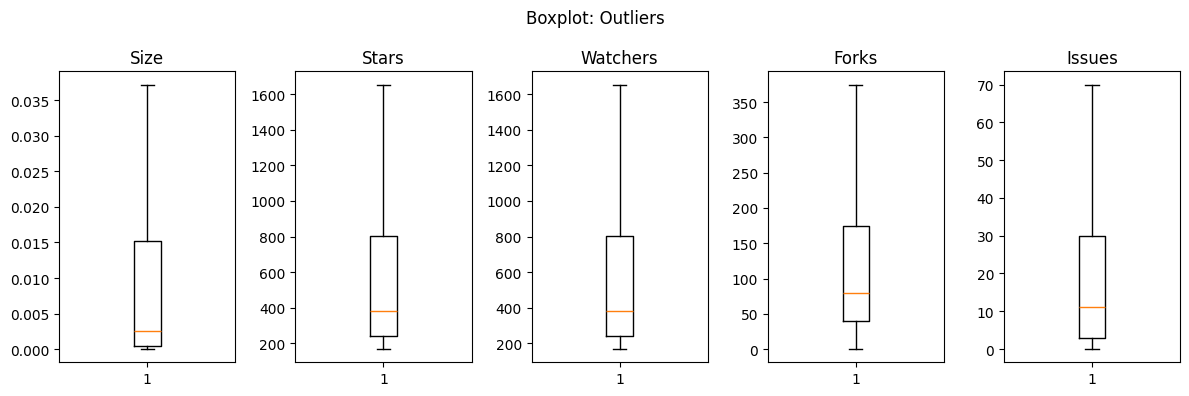

In [156]:
fig, axes = plt.subplots(nrows=1,ncols=5, figsize=(12, 4))
for i,f in enumerate(['Size','Stars','Watchers','Forks','Issues']):
    axes[i].boxplot(df[f])
    axes[i].set_title(f)
fig.suptitle("Boxplot: Outliers")
plt.tight_layout()
# plt.axis('off')

In [148]:
def remove_outliers(dataFrame, col):
    Q1 = dataFrame[col].quantile(0.25)
    Q3 = dataFrame[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    if dataFrame[col].dtype in ['int32','int64']:
        lower_fence, upper_fence = int(lower_fence), int(upper_fence)

    outliers = dataFrame[col].where(
        (dataFrame[col] < lower_fence) & (dataFrame[col] > upper_fence))

    status = 'Removed'
    try:
        for i, d in dataFrame.iterrows():
            if d[col] < lower_fence:
                df.at[i, col] = lower_fence
            elif d[col] > upper_fence:
                df.at[i, col] = upper_fence
    except:
        status = 'Not Removed'
    finally:
        print(f"{col:<10}{status:>10}")

In [149]:
print(f"{'Column':<10}{'Status':>10}")
for c in ['Size','Stars','Watchers','Forks','Issues']:
    remove_outliers(df, c)

Column        Status
Size         Removed
Stars        Removed
Watchers     Removed
Forks        Removed
Issues       Removed


# Creating a Popularity Score

A Popular Repo will have the following features --

- Increases Popularity
  - Stars
  - Forks
  - Watching
  - Downloads
  - Discussions (Indicates an active community)

- Decreases Popularity
  - Issues

- Not Necessary
  - Number of Branches
  - Pages
  - Template

- Improve QoL
  - Wiki

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
mss = MinMaxScaler(feature_range=(-10,10))
ss_fit = mss.fit_transform(df[['Stars','Forks','Watchers','Issues']])
df[['Stars','Forks','Watchers','Issues']] = pd.DataFrame(ss_fit,columns=['Stars','Forks','Watchers','Issues'])

In [6]:
df['popular_score'] = (df['Stars']+df['Forks']) / (1+df['Issues'])

In [164]:
df[['popular_score','Stars','Forks','Issues']].sort_values('popular_score').sample(10)

,popular_score,Stars,Forks,Issues
68590,3.508681,-4.825269,-2.693333,-3.142857
133636,1.604463,-8.750000,-4.773333,-9.428571
3653,1.818182,10.000000,10.000000,10.000000
77385,1.643814,-5.752688,-6.693333,-8.571429
151492,2.742586,-9.247312,-7.600000,-7.142857
123135,2.391508,-8.413978,-6.960000,-7.428571
70234,1.061870,-5.013441,-4.240000,-9.714286
186188,2.807527,-9.919355,-9.733333,-8.000000
191127,1.959987,-9.986559,-6.533333,-9.428571
64263,1.538233,-4.287634,-6.480000,-8.000000


In [167]:
df['popular_score'].describe()

count    192060.000000
mean          1.334073
std          11.556620
min        -140.000000
25%           0.244851
50%           1.813425
75%           2.346275
max         140.000000
Name: popular_score, dtype: float64

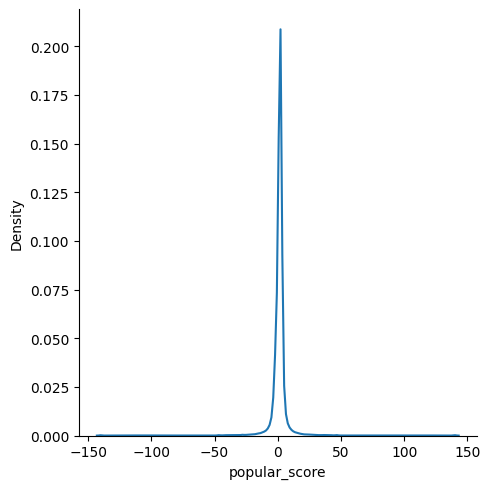

In [168]:
sns.displot(data=df,x='popular_score',kind='kde')

In [ ]:
for i,d in df.iterrows():
    if d['popular_score'] < df['popular_score'].median():
        df.at[i,'Popular'] = 0
    else:
        df.at[i,'Popular'] = 1
    print(i)

In [171]:
# df.to_csv("./data/ScaledScore.csv",index=False)

In [130]:
ss_fit['Cat'].value_counts()

Cat
Popular        24876
Not Popular    23139
Name: count, dtype: int64

In [145]:
corr_mat_int = ss_fit[['test_score','Stars','Forks','Issues']].corr(method='pearson')
px.imshow(
    corr_mat_int,
    text_auto=True,
    aspect='auto',
    color_continuous_scale='purp'
)

# Clustering

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [18]:
interia, sil = [], []
ssd = StandardScaler().fit_transform(X)
for i in range(2,11):
    km = KMeans(n_clusters=i)
    km.fit(ssd)
    interia.append(km.inertia_)
    sil.append(silhouette_score(ssd,km.labels_))

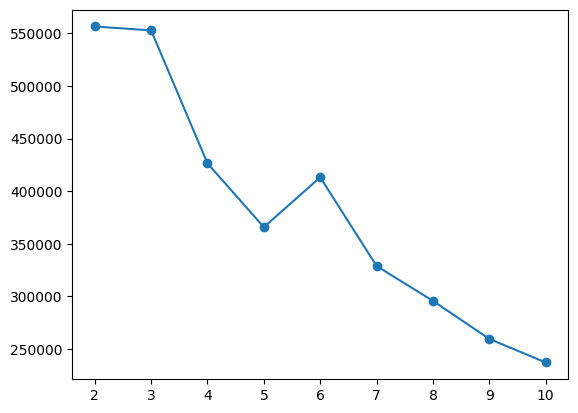

In [20]:
plt.plot(range(2,11), interia, marker = 'o')

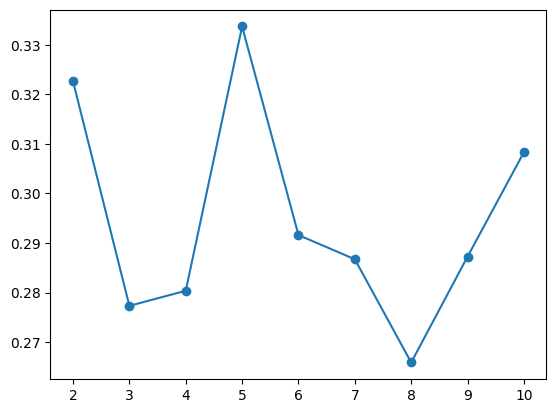

In [19]:
plt.plot(range(2,11), sil, marker = 'o')

In [26]:
km = KMeans(n_clusters=5)
pred_km = km.fit_predict(ssd)


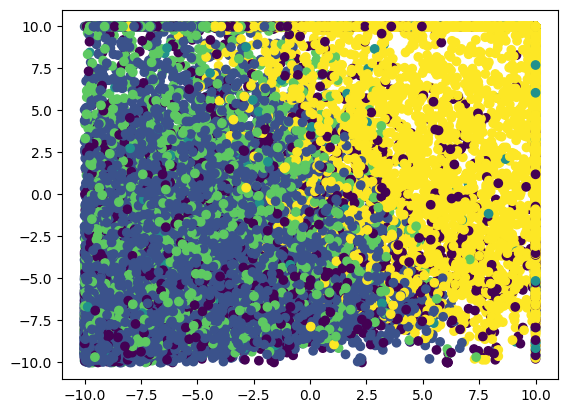

In [88]:
plt.scatter(X['Stars'],X['Forks'],c=pred_km)


In [121]:
fig = px.scatter_3d(
    x=X['Stars'][0:1000],
    y=X['Forks'][0:1000],
    z=X['Issues'][0:1000],
    color=pred_km[0:1000],
    color_continuous_scale='viridis',
    symbol=pred_km[0:1000],
    opacity=0.8
)

fig.update_layout(margin=dict(l=0,r=0,b=0,t=0))
fig.show()

# Models

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48015 entries, 187678 to 83061
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Size               48015 non-null  float64
 1   Stars              48015 non-null  float64
 2   Forks              48015 non-null  float64
 3   Issues             48015 non-null  float64
 4   Watchers           48015 non-null  float64
 5   HasIssues          48015 non-null  int64  
 6   HasProjects        48015 non-null  int64  
 7   HasDownloads       48015 non-null  int64  
 8   HasWiki            48015 non-null  int64  
 9   HasDiscussions     48015 non-null  int64  
 10  Maintained         48015 non-null  int64  
 11  Age                48015 non-null  int64  
 12  IsPopularLang      48015 non-null  int64  
 13  DescSize           48015 non-null  int64  
 14  recent_(0.0, 2.0]  48015 non-null  int64  
 15  recent_(2.0, 4.0]  48015 non-null  int64  
 16  popular_score      480

In [9]:
drop_col = list(bf_scores.sort_values(1,ascending=False).head(5)[0])
drop_col.append('Popular')
drop_col.append('popular_score')

NameError: name 'bf_scores' is not defined

In [10]:
Y = df['Popular']
X = df.drop(['Maintained','recent_(0.0, 2.0]','recent_(2.0, 4.0]','Forks','Stars','Issues','Popular','popular_score'],axis=1)
# X = df.drop(drop_col,axis=1)

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=101)

Scaling

In [12]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-10,10))
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = scaler.transform(X_test)

In [14]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score,roc_curve

In [13]:
def plot_roc(y,pred):
    fpr, tpr, thresholds = roc_curve(y,pred)
    plt.plot(fpr,tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48015 entries, 187678 to 83061
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Size            48015 non-null  float64
 1   Watchers        48015 non-null  float64
 2   HasIssues       48015 non-null  int64  
 3   HasProjects     48015 non-null  int64  
 4   HasDownloads    48015 non-null  int64  
 5   HasWiki         48015 non-null  int64  
 6   HasDiscussions  48015 non-null  int64  
 7   Age             48015 non-null  int64  
 8   IsPopularLang   48015 non-null  int64  
 9   DescSize        48015 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 4.0 MB


## Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
parameters_rf_1 = {
    "n_estimators" : [10, 20, 50, 100, 120, 150, 200, 250, 300, 350, 400, 500],
    "criterion" : ['gini', 'entropy'],
    "max_depth" : [3, 4, 5, 6, 7],
    "min_samples_split" : [2, 3]
}

In [27]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,Y_train)
rf_pred_test = rf_model.predict(X_test)

cm_rf = confusion_matrix(Y_test, rf_pred_test)

print("Accuracy: ",accuracy_score(Y_test,rf_pred_test)*100)
print("Confusion Matrix: \n", cm_rf)
print("................................")
print("Classification report \n: ", classification_report(Y_test, rf_pred_test))

Accuracy:  71.6234510048943
Confusion Matrix: 
 [[3377 1376]
 [1349 3501]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.71      0.71      0.71      4753
         1.0       0.72      0.72      0.72      4850

    accuracy                           0.72      9603
   macro avg       0.72      0.72      0.72      9603
weighted avg       0.72      0.72      0.72      9603



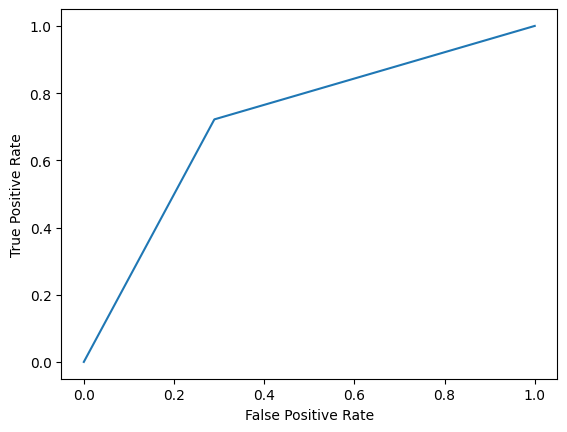

In [28]:
plot_roc(Y_test,rf_pred_test)

## XGBOOST

In [23]:
from xgboost import XGBClassifier

In [24]:
xgb = XGBClassifier(random_state=1119)
xgb.fit(X_train,Y_train)
xgb_pred_test = xgb.predict(X_test)


cm_xgb = confusion_matrix(Y_test, xgb_pred_test)

print("Accuracy: ",accuracy_score(Y_test,xgb_pred_test)*100)
print("Confusion Matrix: \n", cm_xgb)
print("................................")
print("Classification report \n: ", classification_report(Y_test, xgb_pred_test))

Accuracy:  73.21670311361032
Confusion Matrix: 
 [[3426 1327]
 [1245 3605]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.73      0.72      0.73      4753
         1.0       0.73      0.74      0.74      4850

    accuracy                           0.73      9603
   macro avg       0.73      0.73      0.73      9603
weighted avg       0.73      0.73      0.73      9603



## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

In [22]:
lr = LogisticRegression()
lr.fit(X_train,Y_train)

lr_pred = lr.predict(X_test)

cm_lr = confusion_matrix(Y_test, lr_pred)

print("Accuracy: ",accuracy_score(Y_test,lr_pred)*100)
print("Confusion Matrix: \n", cm_lr)
print("................................")
print("Classification report \n: ", classification_report(Y_test, lr_pred))

Accuracy:  66.11475580547746
Confusion Matrix: 
 [[2465 2288]
 [ 966 3884]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.72      0.52      0.60      4753
         1.0       0.63      0.80      0.70      4850

    accuracy                           0.66      9603
   macro avg       0.67      0.66      0.65      9603
weighted avg       0.67      0.66      0.65      9603



## AdaBoost

In [16]:
from sklearn.ensemble import AdaBoostClassifier

In [31]:
adab = AdaBoostClassifier()
adab.fit(X_train,Y_train)
adab_pred = adab.predict(X_test)
cm_adab = confusion_matrix(Y_test,adab_pred)
print("Accuracy: ",accuracy_score(Y_test,adab_pred)*100)
print("Confusion Matrix: \n", cm_adab)
print("................................")
print("Classification report \n: ", classification_report(Y_test, adab_pred))

d:\Uzair\1 Projects\GitRepo-Analysis\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:  70.89451213162553
Confusion Matrix: 
 [[3323 1430]
 [1365 3485]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.71      0.70      0.70      4753
         1.0       0.71      0.72      0.71      4850

    accuracy                           0.71      9603
   macro avg       0.71      0.71      0.71      9603
weighted avg       0.71      0.71      0.71      9603



## SVM

In [33]:
from sklearn.svm import SVC

In [35]:
sv = SVC(kernel='rbf',random_state=42)
sv.fit(X_train,Y_train)
sv_pred = sv.predict(X_test)
cm_sv = confusion_matrix(Y_test,sv_pred)
print("Accuracy: ",accuracy_score(Y_test,sv_pred)*100)
print("Confusion Matrix: \n", cm_sv)
print("................................")
print("Classification report \n: ", classification_report(Y_test, sv_pred))

Accuracy:  73.32083723836301
Confusion Matrix: 
 [[3355 1398]
 [1164 3686]]
................................
Classification report 
:                precision    recall  f1-score   support

         0.0       0.74      0.71      0.72      4753
         1.0       0.73      0.76      0.74      4850

    accuracy                           0.73      9603
   macro avg       0.73      0.73      0.73      9603
weighted avg       0.73      0.73      0.73      9603

